# U-net with attention

# https://youtu.be/L5iV5BHkMzM
"""
Attention U-net:
https://arxiv.org/pdf/1804.03999.pdf
Recurrent residual Unet (R2U-Net) paper
https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
(Check fig 4.)
Note: Batch normalization should be performed over channels after a convolution, 
In the following code axis is set to 3 as our inputs are of shape 
[None, height, width, channel]. Channel is axis=3.
Original code from below link but heavily modified.
https://github.com/MoleImg/Attention_UNet/blob/master/AttResUNet.py
"""

In [149]:
# %matplotlib notebook

In [355]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

import tensorflow_addons as tfa

from focal_loss import BinaryFocalLoss

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from skimage import io, color, measure
from skimage.util import img_as_float32, img_as_ubyte
from skimage.morphology import skeletonize

from scipy import ndimage

import cv2

import time

# Function for models building and evaluation

In [2]:
# A few useful metrics and losses

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def dmap_diffrence(y_true, y_pred):
    # distance map diffrence, squared
    # used as metric

    y_true_inv = (y_true == 0)
    y_true_inv = tf.cast(y_true_inv, tf.uint8)
    y_true_distance_map = tfa.image.euclidean_dist_transform(y_true_inv)  
    
    y_pred_inv = (y_pred < 0.5)
    y_pred_inv = tf.cast(y_pred_inv, tf.uint8)
    y_pred_distance_map = tfa.image.euclidean_dist_transform(y_pred_inv)
    
    diff_map = tf.subtract(y_pred_distance_map, y_true_distance_map)
    diff_map = tf.math.abs(diff_map)

    return tf.keras.backend.mean(diff_map)

In [3]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

    
def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    2. conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation                                     
    
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path


def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [4]:
# models
def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
   
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
   
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
   
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model 
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model


def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model


def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [5]:
def plot_history(history):
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 3, 1)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.legend()

    plt.subplot(1, 3, 2)
    acc = history.history['jacard_coef']
    val_acc = history.history['val_jacard_coef']
    plt.plot(epochs, acc, 'y', label='jacard_coef acc')
    plt.plot(epochs, val_acc, 'r', label='val_jacard_coef')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 3)    
    acc2 = history.history['dmap_diffrence']
    val_acc2 = history.history['val_dmap_diffrence']
    plt.plot(epochs, acc2, 'g', label='dmap_diffrence')
    plt.plot(epochs, val_acc2, 'b', label='val_dmap_diffrence')
    plt.title('Average distance map diffrence')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 10)
    plt.legend()
    plt.grid()
    plt.show()

In [6]:
def preview_predict(X, y_true=None, model=None):
    # creates a preview of the prediction
    if model is None:
        model = model
    X = np.expand_dims(X, axis=0)
    y_pred = model.predict(X)[0]
    print(f"predicted max: {y_pred.max()}; min {y_pred.min()}")
    y_pred_thresholded = y_pred > 0.5

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.imshow(X[0], cmap='gray')
    plt.title("Input image")    
    if y_true is not None:
        plt.subplot(2, 2, 2)
        plt.imshow(y_true, cmap='gray')
        plt.title("true borders")   
        
    plt.subplot(2, 2, 3)
    im = plt.imshow(y_pred, cmap='jet')
    plt.colorbar(im)
    plt.title("predicted")    
    plt.subplot(2, 2, 4)
    plt.imshow(y_pred_thresholded, cmap='gray')
    plt.title("predicted thresh 0.5")
    # plt.subplot(1, 3, 3)
    # plt.hist(y_pred.ravel(), bins="fd")
    plt.show()
    
    
def visual_eval(model=None, show=True, test_img=None, mask_expected=None, thresh = 0.5):
    """
    provides visual evaluation for the performance of the model
    if no image or mask is provided, it will use hard coded picture.
    """
    if model is None:
        model = model
#     if test_img == None or mask_expected == None:
#         test_img = io.imread(r"train_test\full_image.tif", as_gray=True)[0:512, 0:512]
#         mask_expected = io.imread(r"train_test\full_image_mask.tif", as_gray=True)[0:512, 0:512]
    test_img = img_as_float32(test_img)
    original_img = test_img.copy()

    X = np.expand_dims(test_img, axis=0)
    X = np.expand_dims(X, axis=-1)
    mask_predicted = model.predict(X)[0, :, :, 0]
    mask_predicted = mask_predicted > thresh # thresholding
    
    img_review = color.gray2rgb(original_img)
    if mask_expected is not None:
        mask_expected = mask_expected.astype(bool)
        img_review[mask_expected & mask_predicted] = (0, 1, 0) # tp, green
        img_review[mask_expected & ~mask_predicted] = (1, 0, 1) # fn, low recall score
        img_review[~mask_expected & mask_predicted] = (1, 0, 0) # fp, low precision score
    else:
        img_review[mask_predicted] = (0, 0, 1) # predicted, blue
    
    if show:
        plt.figure(figsize=(12,12))
        plt.imshow(img_review)
        plt.title("Mark-up picture")
        plt.show()
    return img_review #, mask_expected, mask_predicted

# Training data preparation

In [7]:
img_full = io.imread(r"train_test\full_image.tif", as_gray=True)
img_full = img_as_float32(img_full)
mask_full = io.imread(r"train_test\full_image_mask_sk.tif", as_gray=True)
mask_full = (mask_full > 0).astype(np.uint8)

In [8]:
def create_patch_tensor(image):
    """
    prepares patches from image.
    the output tensor is with shape [25, 176, 256, 1]
    """
    im = np.expand_dims([image], -1)
    p = tf.image.extract_patches(images=im,
                           sizes=[1, 176, 256, 1],
                           strides=[1, 176, 256, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID') # small size of the image is lost
    n, r, c = p.shape[0], p.shape[1], p.shape[2]
    if r != 5 or c !=5:
        print(f"The function is intende for input shape of 880-893x1280 but shape {image.shape} was given")
    p = tf.reshape(p, [n*r*c, 176, 256, 1])
    return p

In [9]:
img_p = create_patch_tensor(img_full)
mask_p = create_patch_tensor(mask_full)
X_train = img_p[:20]
X_test = img_p[20:]
y_train = mask_p[:20]
y_test = mask_p[20:]

In [10]:
X_train.shape, X_test.shape

(TensorShape([20, 176, 256, 1]), TensorShape([5, 176, 256, 1]))

# Parameters for the model

In [11]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 2

# U-net model

In [12]:
# tf.keras.backend.clear_session()

In [13]:
# tf.random.set_seed(10)
unet_model = UNet(input_shape)
unet_model.compile(optimizer=Adam(learning_rate = 1e-2),
                   loss=BinaryFocalLoss(gamma=2), 
#                    loss = 'binary_crossentropy',
                   metrics=[jacard_coef, dmap_diffrence] 
                  )

unet_model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 176, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 176, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [14]:
unet_model.load_weights('Unet_BFloss_sk_100ep.hdf5')

In [15]:
# start1 = time.time() 
# unet_history = unet_model.fit(X_train, y_train,
#                                 batch_size = batch_size,
#                                 validation_data=(X_test, y_test), 
#                                 epochs=100) 
# stop1 = time.time()
# execution_time_Unet = stop1 - start1
# print("UNet execution time is: ", execution_time_Unet)

# unet_model.save('Unet_BFloss_sk_100ep.hdf5')

Working solution 1: binary cross entropy + 100/150 epoches
Working solution 2: loss=BinaryFocalLoss(gamma=2) + 150 epoches (100 epoches is better)

### Evaluation

In [16]:
# plot_history(unet_history)

predicted max: 0.9056357741355896; min 5.111846803629305e-06


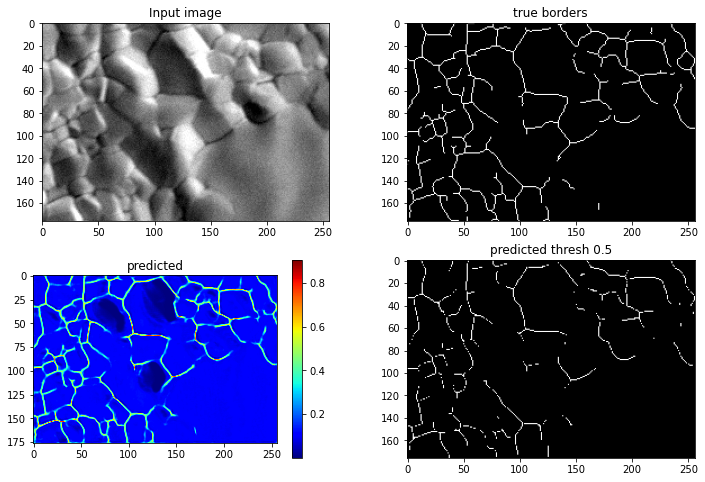

In [17]:
preview_predict(X_train[3], y_train[3], model=unet_model)

predicted max: 0.8649930953979492; min 3.622255690061138e-06


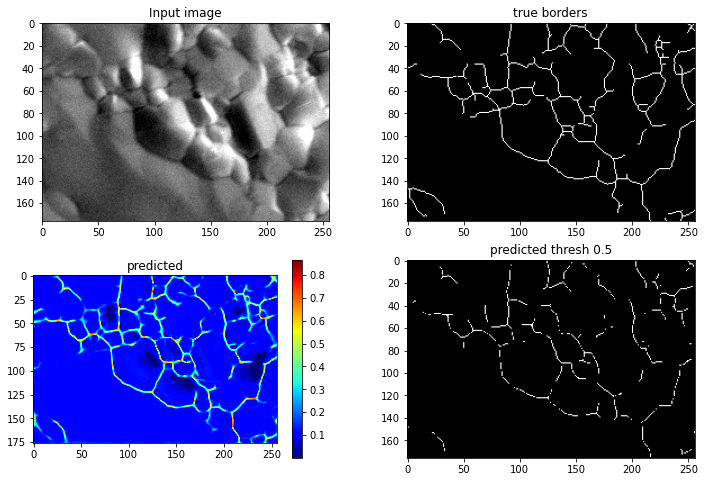

In [18]:
preview_predict(X_test[3], y_test[3], model=unet_model)

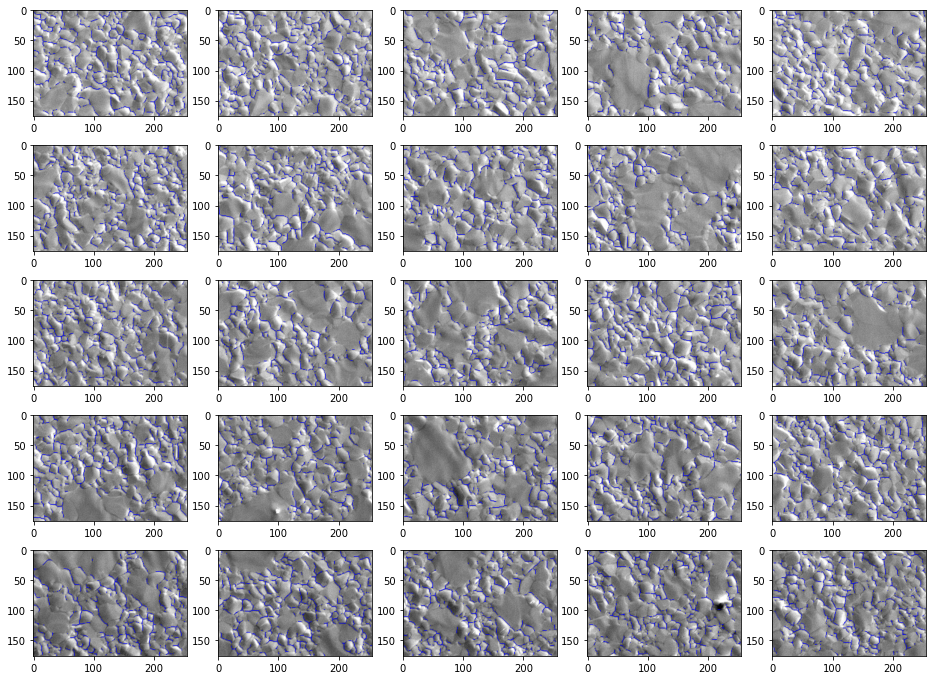

In [19]:
# production
img = io.imread(r"production_input\DV7 CeramTec Rubalit 710S aft. 1370C 04.jpg", as_gray=True)[2:895,:]
img = img_as_float32(img)
img_p = create_patch_tensor(img)

plt.figure(figsize=(16,12))
for i in range(5*5):
    plt.subplot(5, 5, i+1)
    preview = visual_eval(model=unet_model, show=False, test_img=img_p[i], mask_expected=None, thresh=0.5)
    preview = np.squeeze(preview)
    plt.imshow(preview)
    f_name = f"production_test/U-net_{i}.tif"
    io.imsave(f_name, img_as_ubyte(preview))
plt.show()

# Attention U-net model

In [20]:
att_unet_model = Attention_UNet(input_shape)
att_unet_model.compile(optimizer=Adam(learning_rate = 1e-2),
                   loss=BinaryFocalLoss(gamma=2), 
#                    loss = 'binary_crossentropy',
                   metrics=[jacard_coef, dmap_diffrence] 
                  )

att_unet_model.summary()

Model: "Attention_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 176, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 176, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 176, 256, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                    

In [21]:
att_unet_model.load_weights('AttUnet_BFloss_sk_100ep.hdf5')

In [22]:
# start2 = time.time() 
# att_unet_history = att_unet_model.fit(X_train, y_train,
#                                 batch_size = batch_size,
#                                 validation_data=(X_test, y_test), 
#                                 epochs=100) 
# stop2 = time.time()
# execution_time_Att_Unet = stop2-start2
# print("Attention UNet execution time is: ", execution_time_Att_Unet)

# att_unet_model.save('AttUnet_BFloss_sk_100ep.hdf5')

### Evaluation

In [23]:
# plot_history(att_unet_history)

predicted max: 0.930435061454773; min 0.010437365621328354


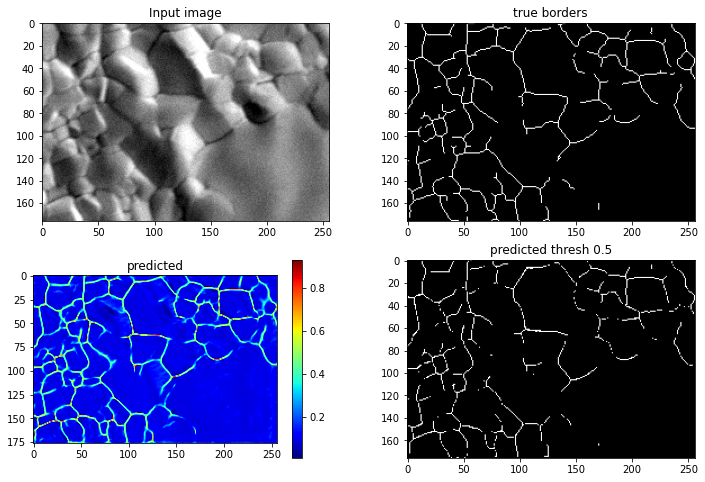

In [24]:
preview_predict(X_train[3], y_train[3], model=att_unet_model)

predicted max: 0.8953027725219727; min 0.007635118439793587


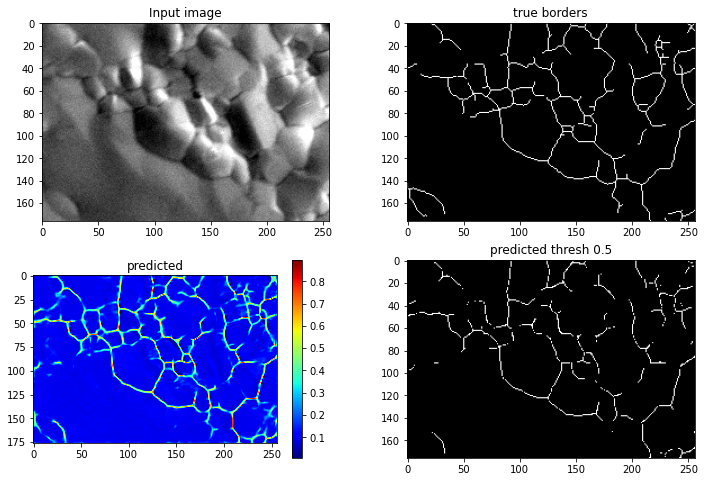

In [25]:
preview_predict(X_test[3], y_test[3], model=att_unet_model)

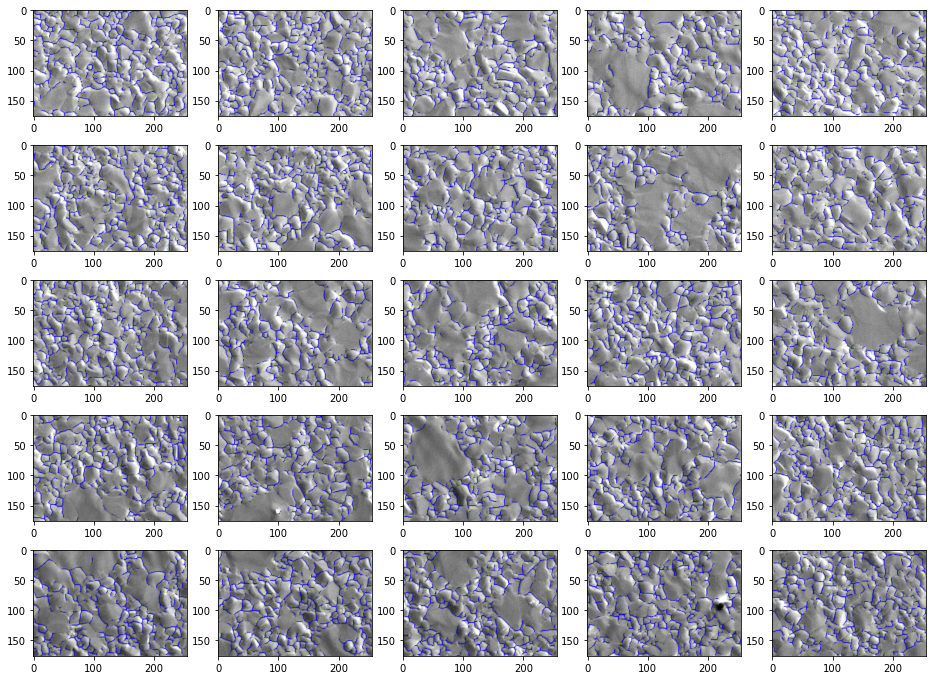

In [26]:
# production
img = io.imread(r"production_input\DV7 CeramTec Rubalit 710S aft. 1370C 04.jpg", as_gray=True)[2:895,:]
img = img_as_float32(img)
img_p = create_patch_tensor(img)

plt.figure(figsize=(16,12))
for i in range(5*5):
    plt.subplot(5, 5, i+1)
    preview = visual_eval(model=att_unet_model, show=False, test_img=img_p[i], mask_expected=None, thresh=0.5)
    preview = np.squeeze(preview)
    plt.imshow(preview)
    f_name = f"production_test/att_U-net_{i}.tif"
    io.imsave(f_name, img_as_ubyte(preview))
plt.show()

# Attention Residual Unet

In [27]:
tf.keras.backend.clear_session()

In [28]:
att_res_unet_model = Attention_ResUNet(input_shape)
att_res_unet_model.compile(optimizer=Adam(learning_rate = 1e-2),
                   loss=BinaryFocalLoss(gamma=2), 
#                    loss = 'binary_crossentropy',
                   metrics=[jacard_coef, dmap_diffrence] 
                  )

att_res_unet_model.summary()

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 176, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 176, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                  

In [29]:
att_res_unet_model.load_weights('AttResUnet_BFloss_sk_100ep.hdf5')

In [30]:
# start3 = time.time() 
# att_res_unet_history = att_res_unet_model.fit(X_train, y_train,
#                                 batch_size = batch_size,
#                                 validation_data=(X_test, y_test), 
#                                 epochs=100) 
# stop3 = time.time()
# execution_time_AttResUnet = stop3 - start3
# print("Attention ResUnet execution time is: ", execution_time_AttResUnet)

# att_res_unet_model.save('AttResUnet_BFloss_sk_100ep.hdf5')

### Evaluation

In [31]:
# plot_history(att_res_unet_history)

predicted max: 0.9145730137825012; min 1.900712226499124e-12


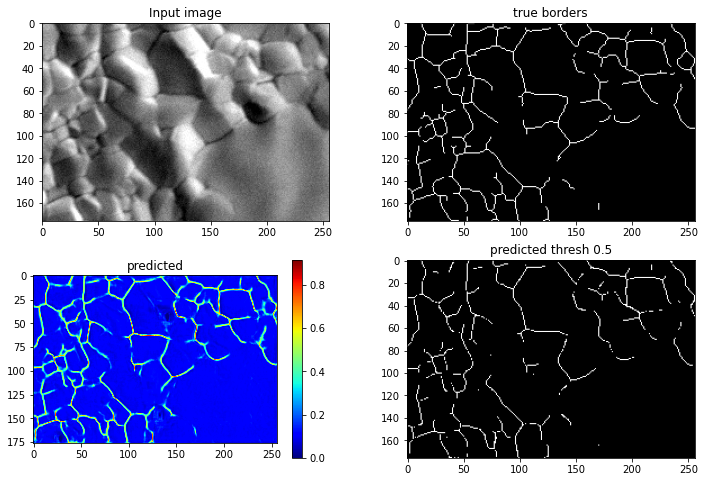

In [32]:
preview_predict(X_train[3], y_train[3], model=att_res_unet_model)

predicted max: 0.9140657186508179; min 8.936342350140065e-19


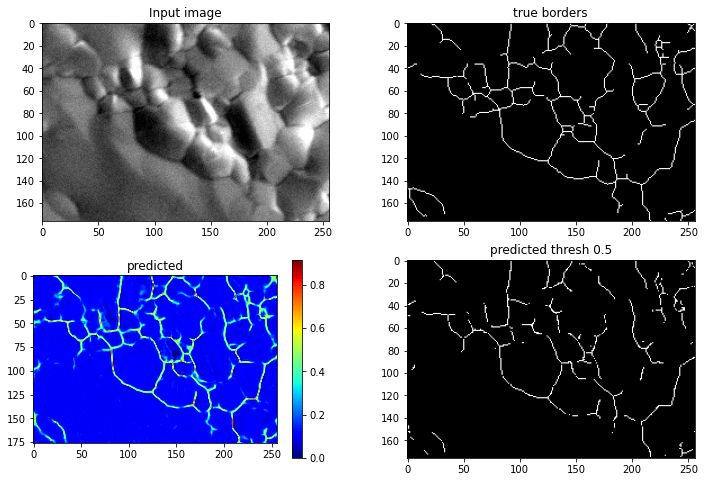

In [33]:
preview_predict(X_test[3], y_test[3], model=att_res_unet_model)

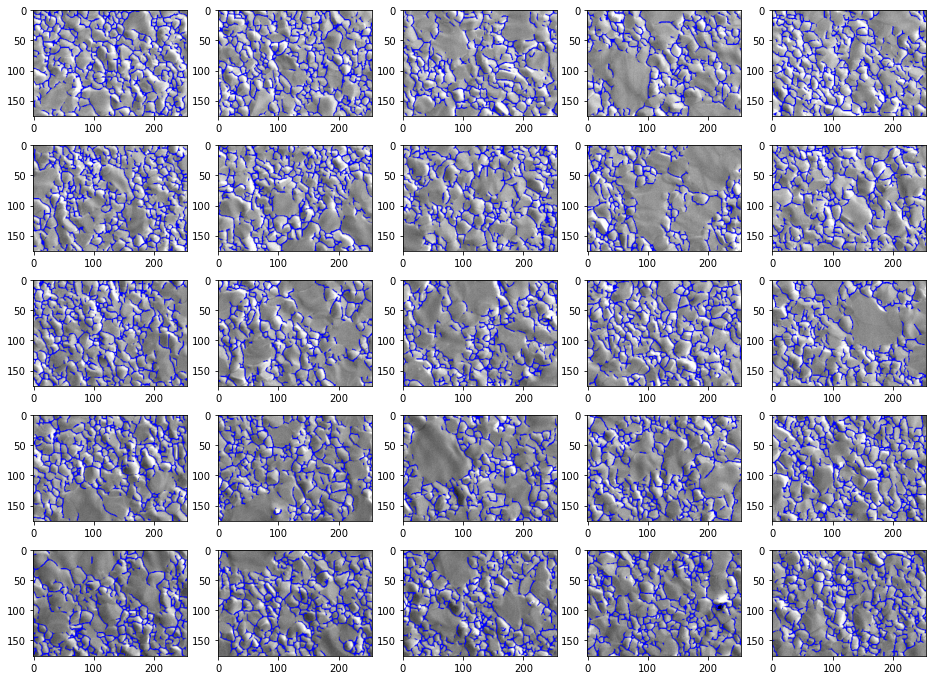

In [34]:
# production
img = io.imread(r"production_input\DV7 CeramTec Rubalit 710S aft. 1370C 04.jpg", as_gray=True)[2:895,:]
img = img_as_float32(img)
img_p = create_patch_tensor(img)

plt.figure(figsize=(16,12))
for i in range(5*5):
    plt.subplot(5, 5, i+1)
    preview = visual_eval(model=att_res_unet_model, show=False, test_img=img_p[i], mask_expected=None, thresh=0.25)
    preview = np.squeeze(preview)
    plt.imshow(preview)
    f_name = f"production_test/att_res_U-net_sk_{i}.tif"
    io.imsave(f_name, img_as_ubyte(preview))
plt.show()

# Next
Create a good prediction on picture with 1000x zoom; train a network on this image

# Creating mask for the 500x pictures

## Existing model comparison

In [40]:
# models: att_res_unet_model, att_unet_model, unet_model
# all trained for 100 epcohes with skeletonized label mask at 1000x picture

In [62]:
# production
img = io.imread(r"production_input\DV7 CeramTec Rubalit 710S aft. 1370C 04.jpg", as_gray=True)[2:895,:]
img = img_as_float32(img)
img_p = create_patch_tensor(img)

test_p = img_p[0:1, :, :, :]

In [139]:
# crete a picture 2x2 including original patch and the three predictions with cmap='jet'
models = {"att_res_unet":att_res_unet_model, "att_unet":att_unet_model, "unet":unet_model}

preview = [0, 0, 0, 0]
preview[0] = tf.repeat(test_p, 3, axis=-1).numpy().squeeze()

i=1
for k, v in models.items():
    pred = v.predict(test_p)
    preview[i] = plt.get_cmap('jet')(pred / pred.max())[:,:,:,:, :3]
    preview[i] = preview[i].squeeze()
    i += 1
    
preview = np.array(preview)
preview = np.reshape(preview, (2, 2, 176, 256, 3))
to_plot = np.hstack(np.hstack(preview))

<IPython.core.display.Javascript object>


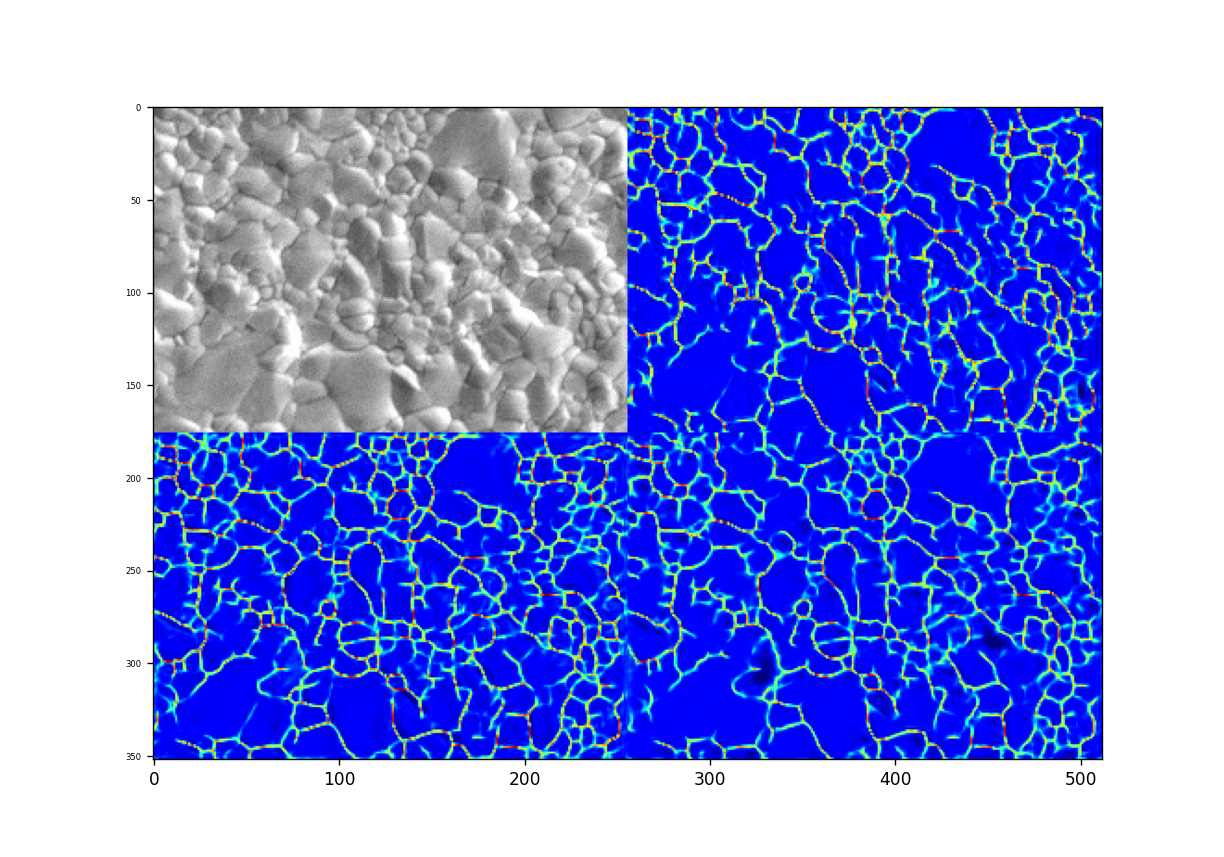

In [256]:
plt.figure(figsize=(10, 7))
plt.imshow(to_plot)

<IPython.core.display.Javascript object>


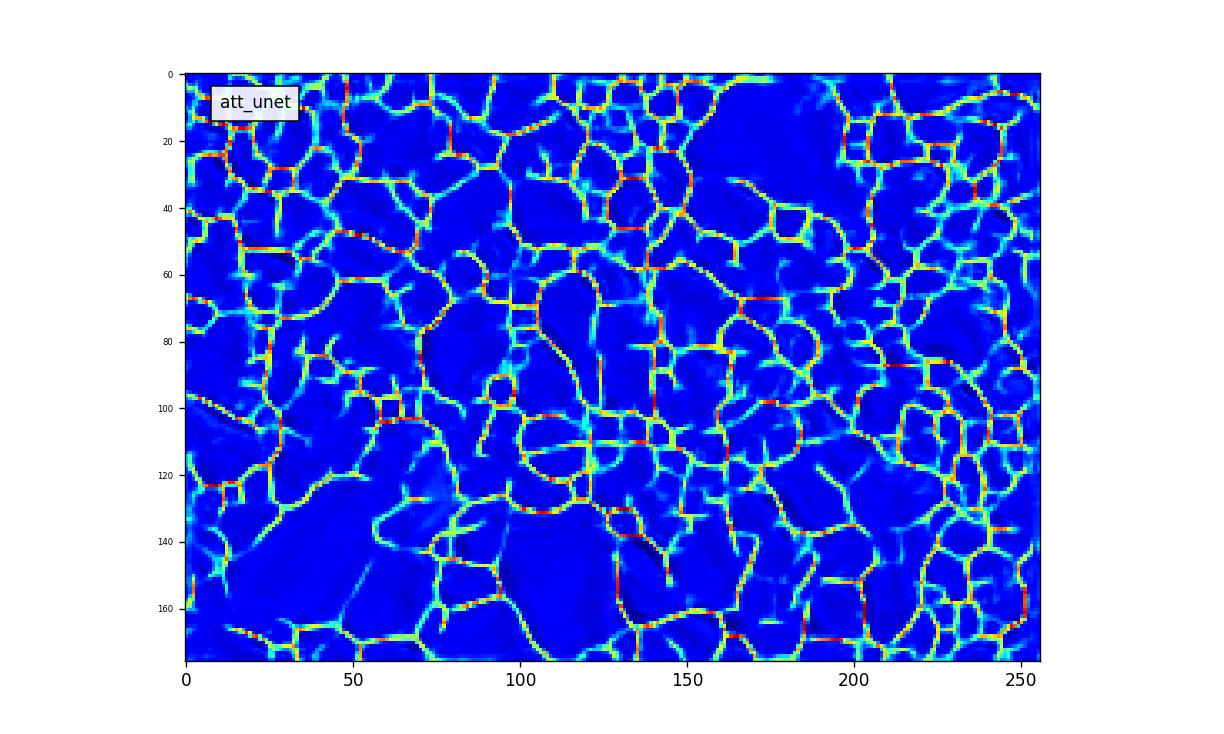

In [316]:
# creating an animation
models = {"unet":unet_model, "att_unet":att_unet_model, "att_res_unet":att_res_unet_model}
fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

title1 = ax.text(10, 10, "picture", bbox={'facecolor':'w', 'alpha':0.9, 'pad':5})        
pic1 = ax.imshow(test_p[0], cmap='gray', animated=True)

ims = [[pic1, title1]]
for k, v in models.items():
    pred = v.predict(test_p)
    title = ax.text(10, 10, k, bbox={'facecolor':'w', 'alpha':0.9, 'pad':5})        
    im = ax.imshow(pred[0], cmap='jet', animated=True)
    ims.append([im, title])

ani = animation.ArtistAnimation(fig, ims, interval=1200, blit=False, repeat=True, repeat_delay=0)
plt.show()

Visual review indicates attention Unet is showing the best results. Now let's adjust the thresholding.

In [330]:
pred = att_unet_model.predict(test_p)

<IPython.core.display.Javascript object>


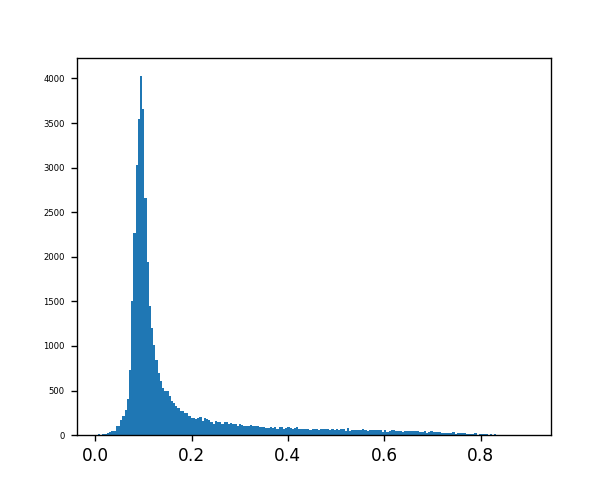

In [331]:
plt.figure(figsize=(5, 4))
plt.hist(pred.ravel(), bins="fd")
plt.show()

<IPython.core.display.Javascript object>


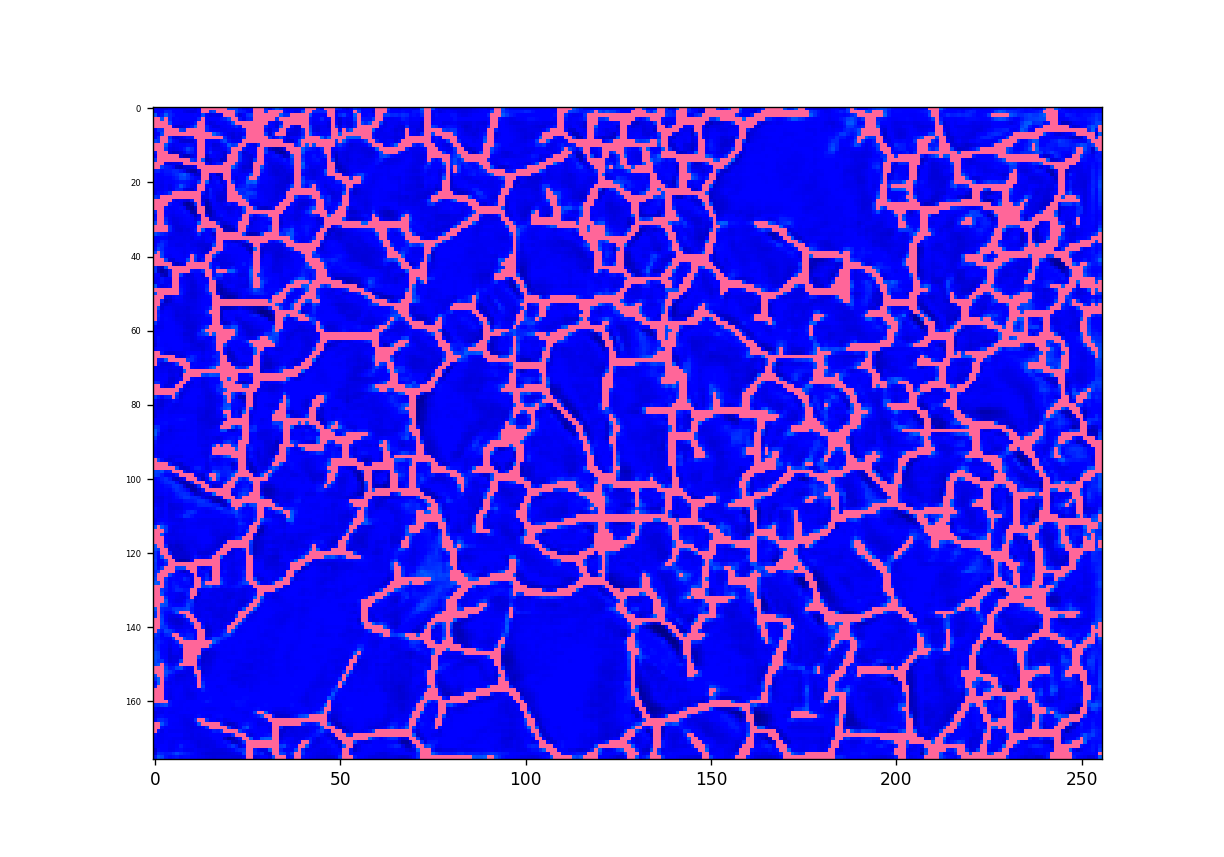

In [339]:
preview = plt.get_cmap('jet')(pred / pred.max())[:,:,:,:, :3]
preview = preview.squeeze()

mask = np.zeros(preview.shape[0:2])
mask[np.squeeze(pred) > 0.20] = 1
preview[mask == 1] = (1,0.4,0.6)

plt.figure(figsize=(10, 7))
im = plt.imshow(preview)
plt.show()

<IPython.core.display.Javascript object>


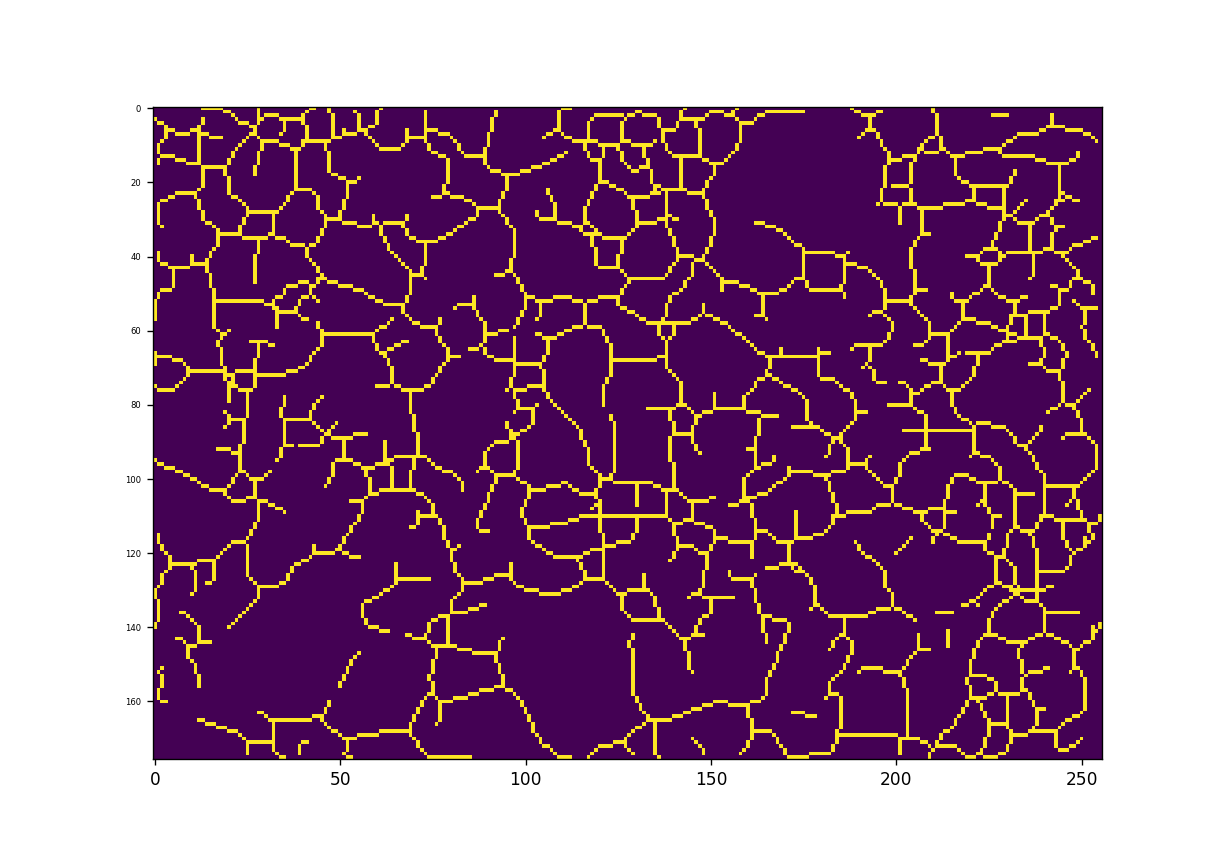

In [359]:
mask_sk = skeletonize(mask)

kernel = np.ones((3,3))
# mask_sk = binary_closing(mask_sk, kernel) # make boundaries more solid
labeled_mask, _ = ndimage.label(mask_sk, structure=kernel)
regions = measure.regionprops(labeled_mask)
for prop in regions:
    if prop.area <= 4:
        # remove small island of border pixels
        mask_sk[labeled_mask == prop.label] = 0
        
plt.figure(figsize=(10, 7))
im = plt.imshow(mask_sk)
plt.show()

# Created colored masks based on 500x image

In [388]:
img = io.imread(r"production_input\DV7 CeramTec Rubalit 710S aft. 1370C 04.jpg", as_gray=True)[2:895,:]
img = img_as_float32(img)
img_p = create_patch_tensor(img)

for i in range(img_p.shape[0]):
    patch = img_p[i, :, :, :]
    patch = np.expand_dims(patch, 0)
    pred = att_unet_model.predict(patch)
    
    mask = np.zeros(pred.shape[1:3])
    mask[np.squeeze(pred) > 0.20] = 1
    mask = skeletonize(mask)
    
    kernel = np.ones((3,3))
    # mask_sk = binary_closing(mask_sk, kernel) # make boundaries more solid
    labeled_mask, _ = ndimage.label(mask, structure=kernel)
    regions = measure.regionprops(labeled_mask)
    for prop in regions:
        if prop.area <= 4:
            # remove small island of border pixels
            mask[labeled_mask == prop.label] = 0
    
    pic = tf.repeat(patch, 3, axis=-1)
    pic = pic[0].numpy()
    pic[mask == 1] = (1, 0, 0)

    io.imsave(f"train_test_500x\patch_{i}_image.tif", img_as_ubyte(np.squeeze(patch)))
    io.imsave(f"train_test_500x\patch_{i}_combined.tif", img_as_ubyte(pic))